# Random Forest RandomSearchCV
Aggregated Invoice Data (Mean Consumption) - Balanced Data - No Dummies

```
2025-05-12 16:59:11
Model performance for Random Forest RandomSearchCV - 
 Aggregated Invoice Data (Mean Consumption). Balanced Data.:

---
    Test Data F1 Score:  0.1989
    Test Data ROC AUC:   0.6837
    Test Data MCC:       0.1804
    Test Data Accuracy:  0.664
    Test Data Precision: 0.1158

```

In [136]:
# Used for filename when saving model
model_ref = "rf_rscv_agg_mean_nodummies_balanced"

# Used for graph titles
model_name = "Random Forest RandomSearchCV"
model_details = "Aggregated Invoice Data (Mean Consumption) - Balanced Data"


In [128]:
import pandas as pd
import numpy as np

import pyarrow
import fastparquet

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

In [ ]:
# Reload model from file if needed

"""
saved_model_filename = "rf_rscv_agg_mean_nodummies_balanced_2025-05-12165911.skops.skops"

unknown_types = get_untrusted_types(file=f"models/{saved_model_filename}")
# investigate the contents of unknown_types, and only load if you trust
# everything you see.
best_model = load(f"models/{saved_model_filename}", trusted=unknown_types)

"""

## Run data cleaning script, generate parquet files. 
Requires pyarrow and fastparquet (see requirements.txt)

In [129]:
# Open and run **ETL_export_parquet_invoice-level_+_client-level_mean.py**

## Import parquet files

In [112]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_no_dummies_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_no_dummies_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarised. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_no_dummies_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_no_dummies_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [113]:
df_train_non_agg

,disrict,client_catg,region,creation_date,target,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type_ELEC,counter_type_GAZ
0,60,11,101,34699,0,11,0,203,8,1.0,82.0,0.0,0.0,0.0,4,True,False
1,60,11,101,34699,0,11,0,203,6,1.0,1200.0,184.0,0.0,0.0,4,True,False
2,60,11,101,34699,0,11,0,203,8,1.0,123.0,0.0,0.0,0.0,4,True,False
3,60,11,101,34699,0,11,0,207,8,1.0,102.0,0.0,0.0,0.0,4,True,False
4,60,11,101,34699,0,11,0,207,9,1.0,572.0,0.0,0.0,0.0,12,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430783,63,11,311,40869,0,40,0,5,9,1.0,118.0,0.0,0.0,0.0,4,False,True
4430784,63,11,311,40869,0,11,0,207,9,1.0,312.0,0.0,0.0,0.0,4,True,False
4430785,63,11,311,40869,0,11,0,207,9,1.0,578.0,0.0,0.0,0.0,4,True,False
4430786,60,11,101,34325,0,10,0,202,9,1.0,400.0,135.0,0.0,0.0,8,True,False


In [114]:
df_final_test_non_agg

,disrict,client_catg,region,creation_date,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type_ELEC,counter_type_GAZ
0,62,11,307,37404,11,0,203,8,1.0,755.0,0.0,0.0,0.0,8,True,False
1,62,11,307,37404,11,0,203,8,1.0,1067.0,0.0,0.0,0.0,8,True,False
2,62,11,307,37404,11,0,203,8,1.0,0.0,0.0,0.0,0.0,4,True,False
3,62,11,307,37404,11,0,203,9,1.0,410.0,0.0,0.0,0.0,4,True,False
4,62,11,307,37404,11,0,203,9,1.0,412.0,0.0,0.0,0.0,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920074,69,11,104,32946,11,0,203,6,1.0,248.0,0.0,0.0,0.0,4,True,False
1920075,69,11,104,32946,11,0,203,6,1.0,260.0,0.0,0.0,0.0,4,True,False
1920076,69,11,104,32946,11,0,203,6,1.0,312.0,0.0,0.0,0.0,4,True,False
1920077,69,11,104,32946,11,0,203,6,1.0,236.0,0.0,0.0,0.0,4,True,False


In [115]:
# Choose dataset to use in this document
df = df_train_agg
df_final_test = df_final_test_agg

In [116]:
df.head()

,disrict,client_catg,region,creation_date,target,transactions_count,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC
0,60,11,101,34699,0,35,11,0,203,9,1.0,352.400000,10.571429,0.000000,0.000000,False,True
1,69,11,107,37405,0,37,11,0,203,9,1.0,557.540541,0.000000,0.000000,0.000000,False,True
2,62,11,301,31484,0,18,11,0,203,9,1.0,798.611111,37.888889,0.000000,0.000000,False,True
3,69,11,105,35257,0,20,11,0,413,9,1.0,1.200000,0.000000,0.000000,0.000000,False,True
4,62,11,303,41926,0,14,11,0,207,9,1.0,663.714286,104.857143,117.357143,36.714286,False,True


In [117]:
df.describe()

,creation_date,target,transactions_count,counter_statue,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4
count,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000
mean,37801.779602,0.059078,34.615531,0.010695,8.781734,1.001211,407.277247,117.619880,27.496823,75.918575
std,4107.568660,0.235772,25.782890,0.160331,0.726306,0.183005,342.787037,756.054243,96.626119,833.338704
min,28161.000000,0.000000,1.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,34858.000000,0.000000,13.000000,0.000000,9.000000,1.000000,220.530312,0.000000,0.000000,0.000000
50%,39018.500000,0.000000,31.500000,0.000000,9.000000,1.000000,355.161002,6.892857,0.000000,0.000000
75%,41108.000000,0.000000,52.000000,0.000000,9.000000,1.000000,533.078947,66.688702,5.560244,0.000000
max,43718.000000,1.000000,434.000000,5.000000,9.000000,40.000000,34024.000000,115683.000000,2400.000000,79179.777778


## Split Data to Train and Test

In [118]:
# Make sure final_test has same dummy columns in as training data (filled with False)
def add_missing_dummy_columns_and_fill_false(train, final_test): 

    cols_missing_from_final_test = (set(train) - set(final_test)) - set(['target'])

    for cols in cols_missing_from_final_test:   
        final_test[cols] = False
    print(f"Adding new cols to final_test: {cols_missing_from_final_test}")

add_missing_dummy_columns_and_fill_false(df, df_final_test)

Adding new cols to final_test: set()


In [119]:
X = df.loc[:, ~df.columns.isin(["target"])]
y = df["target"]
X_final_test = df_final_test

# make sure column order the same in X and X_final_test
X, X_final_test = X.align(X_final_test, join="right", axis=1)

RSEED = 42

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=RSEED
)


### Balance Classes

In [120]:

## Balance classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

## Imputing missing values

In [121]:
# % of missing values for each column in Training data
(100 * df.isnull().sum() / df.count()).sort_values(ascending=False)

disrict                 0.0
reading_remarque        0.0
counter_type_GAZ        0.0
consommation_level_4    0.0
consommation_level_3    0.0
consommation_level_2    0.0
consommation_level_1    0.0
counter_coefficient     0.0
counter_code            0.0
client_catg             0.0
counter_statue          0.0
tarif_type              0.0
transactions_count      0.0
target                  0.0
creation_date           0.0
region                  0.0
counter_type_ELEC       0.0
dtype: float64

In [122]:
# % of missing values for each column in the final test data. Compare with training data above to see if similar proportion.
(100 * df_final_test.isnull().sum() / df_final_test.count()).sort_values(ascending=False)

disrict                 0.0
client_catg             0.0
region                  0.0
creation_date           0.0
transactions_count      0.0
tarif_type              0.0
counter_statue          0.0
counter_code            0.0
reading_remarque        0.0
counter_coefficient     0.0
consommation_level_1    0.0
consommation_level_2    0.0
consommation_level_3    0.0
consommation_level_4    0.0
counter_type_GAZ        0.0
counter_type_ELEC       0.0
dtype: float64

In [123]:
# What does the data look like for rows with missing data
df_missing_values = df[pd.isnull(df["transactions_count"]) == True]

In [124]:
X_train_resampled

,disrict,client_catg,region,creation_date,transactions_count,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC
0,69,11,107,38240,22,11,0,207,9,1.0,403.363636,0.000000,0.000000,0.000000,True,True
1,69,11,104,36136,26,11,0,413,9,1.0,964.730769,0.000000,0.000000,0.000000,True,True
2,60,11,101,28458,30,11,0,410,8,1.0,2598.300000,91.000000,0.000000,0.000000,False,True
3,63,11,311,40522,4,11,0,203,8,1.0,1339.750000,174.500000,0.000000,0.000000,False,True
4,69,11,103,39233,63,11,0,207,9,1.0,159.301587,0.000000,0.000000,0.000000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168609,69,11,103,30404,53,11,0,203,9,1.0,762.905660,141.358491,9.528302,0.000000,True,True
168610,69,11,105,39801,52,11,0,207,9,1.0,246.442308,5.442308,0.000000,0.000000,True,True
168611,69,11,104,31201,26,11,0,413,9,1.0,639.000000,352.076923,30.769231,84.846154,True,True
168612,63,11,311,32976,40,40,0,5,9,1.0,314.300000,30.725000,16.550000,0.000000,True,True


In [125]:
y_train_resampled.value_counts()

target
0    84307
1    84307
Name: count, dtype: int64

In [126]:
# pipeline

# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(X_train_resampled.columns[X_train_resampled.dtypes==object])

num_features = list(X_train_resampled.columns[X_train_resampled.dtypes!=object])

from sklearn.pipeline import Pipeline

# Pipeline for numeric features 
num_transformer = Pipeline([
    ('imputer_num', SimpleImputer(missing_values=0, strategy='mean')), # replace 0 with means 
   # ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_transformer = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
   # ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
],
    n_jobs=8)

# Train Model

In [ ]:
param_dist = {
    'classifier__n_estimators': np.arange(10, 201).astype(int),
    'classifier__max_depth': [None] + list(np.arange(3, 21).astype(int)),
    'classifier__max_features': ['sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'classifier__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}
param_dist2 = {
    'classifier__n_estimators': np.arange(10, 201).astype(int),
    'classifier__max_depth': list(np.arange(3, 21).astype(int)),
    'classifier__max_features': ['sqrt'] + list(np.arange(0.5, 1, 0.1)),
    'classifier__max_leaf_nodes': list(np.arange(10, 51).astype(int)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

# Estimator for use in random search
#estimator = RandomForestClassifier(random_state = RSEED)

# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = RSEED, n_jobs=-1))
])

random_search = RandomizedSearchCV(
    pipe, param_dist2, 
    n_iter=50, #100
    cv=5, 
    scoring="f1", verbose=3, n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)

print(f"Best F1 score: {random_search.best_score_}")


# Save best model for future use

# https://scikit-learn.org/stable/model_persistence.html#skops-persistence

best_model = random_search.best_estimator_

timestamp_for_filename = time.strftime("%Y-%m-%d_%H%M%S")

filepath = f"./models/{model_ref}_{timestamp_for_filename}.skops"

obj = dump(best_model, filepath)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best F1 score: 0.7139727789940628


## Metrics for Best Model

In [99]:
train_probs = best_model.predict_proba(X_train_resampled)[:, 1]
test_probs = best_model.predict_proba(X_test)[:, 1]

y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)

Model performance for
 Random Forest RandomSearchCV - Aggregated Invoice Data (Mean Consumption). Balanced Data.:
---------------
Train Data F1 Score:  0.7149
Train Data ROC AUC:   0.7032
Train Data MCC:       0.4077
Train Data Accuracy:  0.7032
Train Data Precision: 0.6877


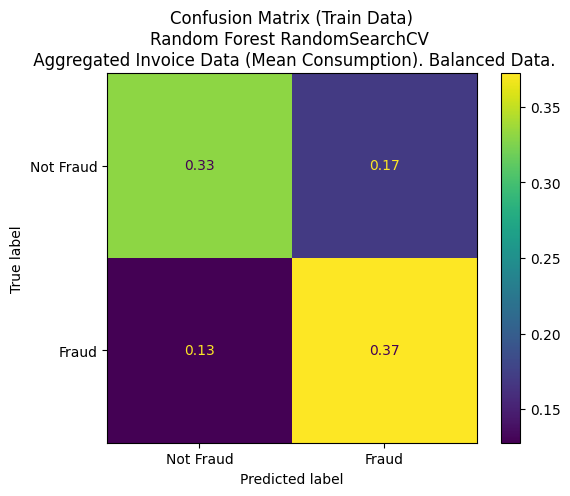

2025-05 12_165911
Model performance for
 Random Forest RandomSearchCV - Aggregated Invoice Data (Mean Consumption). Balanced Data.:
---------------
Test Data F1 Score:  0.1989
Test Data ROC AUC:   0.6837
Test Data MCC:       0.1804
Test Data Accuracy:  0.664
Test Data Precision: 0.1158


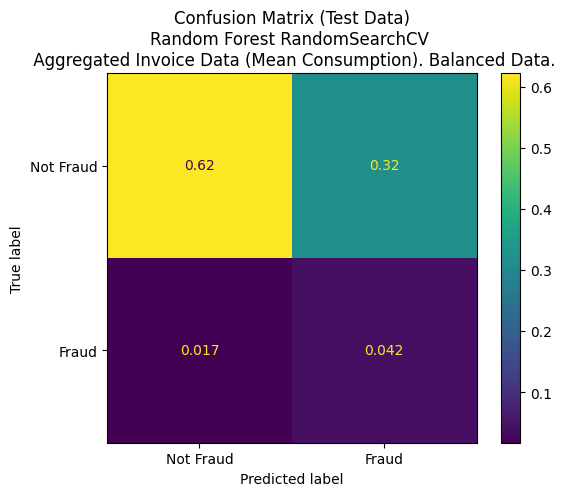

In [132]:
import metrics_plot_functions as mep

mep.print_metric_stats(
    title= f"{model_name} - {model_details}",
    train_or_test="Train Data",
    actual_vals=y_train_resampled,
    predicted_vals=y_train_pred,
    )

mep.output_confusion_matrix(
    train_or_test="Train Data",
    actual_vals=y_train_resampled,
    predicted_vals=y_train_pred,
    display_labels=["Not Fraud", "Fraud"],
    title=f"{model_name} \n {model_details}",
)

print("========================")
print(timestamp_for_filename)

mep.print_metric_stats(
    title= f"{model_name} - {model_details}",
    train_or_test="Test Data",
    actual_vals=y_test,
    predicted_vals=y_test_pred)

mep.output_confusion_matrix(
    train_or_test="Test Data",
    actual_vals=y_test,
    predicted_vals=y_test_pred,
    display_labels=["Not Fraud", "Fraud"],
    title=f"{model_name} \n {model_details}",
)

In [ ]:
best_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=8,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(missing_values=0))]),
                                                  ['creation_date',
                                                   'transactions_count',
                                                   'counter_statue',
                                                   'reading_remarque',
                                                   'counter_coefficient',
                                                   'consommation_level_1',
                                                   'consommation_level_2',
                                                   'consommation_level_3',
                                                   'consommatio